# Import library

In [11]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(10)

# Function to transform the data

In [12]:
# Function to transfer from dBW to W (power)
def db2pow(db):
    return 10**(db/10)

# Function to transfer from W to dBW (power)
def pow2db(pow):
    return 10*np.log10(pow)

# Hermitian transpose of a matrix
def HermTranspose(x):
    return x.conj().T

def chanGen(zeta, d, dim1, dim2):
    """Function to generate Rayleigh fading channel coefficients

    Args:
        zeta: ξ is the path loss exponent
        d: the distance between the transmitter and the receiver
        dim1: the number of rows in the channel matrix
        dim2: the number of columns in the channel matrix
    """
    pl_ref = -30                                    # pathloss (dBW) at reference distance
    pl = db2pow(pl_ref - 10*zeta*np.log10(d))       # pathloss model at distance d
    y = np.sqrt(0.5*pl)*(np.random.randn(dim1,dim2)\
        + 1j*np.random.randn(dim1,dim2))            # Rayleigh distribution
    return y

In [13]:
def generate_random_beamforming_vectors():
    # Generate random complex numbers for each element of the beamforming vector
    beamforming_vectors = [(np.random.randn(N, 1) + 1j * np.random.randn(N, 1)) for i in range (number_of_users)]
    
    # Normalize the vectors
    for i in range (number_of_users):
        beamforming_vectors[i] = beamforming_vectors[i] / np.linalg.norm(beamforming_vectors[i])
    return beamforming_vectors
    #w: list of beamforming vectors, length = number of users, elements are N x 1

def generate_random_theta():
    realPart = np.random.randn(1, Nris)
    imagPart = np.random.randn(1, Nris)
    theta = realPart + 1j * imagPart
    theta = np.exp(1j * np.angle(theta))  # Normalize theta to the unit circle
    return theta
    #theta: phase shift of RIS, size 1 x Nris

def generateChannel():
    normFact = 1/np.sqrt(sigma)
    Hai = chanGen(zetaAI, dAI, Nris, N)                                                         # Alice to RIS channel
    hib = [normFact*chanGen(zetaIB, dIB[i], 1, Nris) for i in range(number_of_users)]           # Channel between the RIS and the legitimate receivers
    hie = [normFact*chanGen(zetaIE, dIE[i], 1, Nris) for i in range(number_of_eavesdroppers)]   # Channel between the RIS and the eavesdroppers
    hab = [normFact*chanGen(zetaAB, dAB[i], 1, N) for i in range(number_of_users)]              # Channel between Alice and the legitimate receivers
    hae = [normFact*chanGen(zetaAE, dAE[i], 1, N) for i in range(number_of_eavesdroppers)]      # Channel between Alice and the eavesdroppers
    return Hai, hib, hie, hab, hae

    #Hai: Channel between Alice and RIS: Nris x N  
    #hib: Channel between RIS and users: List of length number_of_users, elements are 1 x Nris
    #hab: Channel between Alice and users: List of length number_of_users, elements are 1 x N
    #hie: Channel between RIS and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x Nris
    #hae: Channel between Alice and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x N

# Objective Function

In [14]:
def secrecy_rate_objective_function(theta, w):
    secrecy_rate = 0
    for k in range(number_of_users):
        R_bk = []
        # Legitimate user k
        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        C_bk = np.log2(1 + gamma_bk)
        
        for m in range(number_of_eavesdroppers):
            # Eavesdropper i
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            C_em = np.log2(1 + gamma_em)
            R_bk.append(C_bk - C_em)
        
        secrecy_rate += max(min(R_bk),0)
    return secrecy_rate

# System parameters

In [15]:
sigma = db2pow(-75)                                                                 # noise power
N = 8                                                                               # number of transmit antennas
Nris = 32                                                                           # number of RIS elements
number_of_users = 4                                                                 # number of users
number_of_eavesdroppers = 2                                                         # number of eavesdroppers
zetaAI = 2.2                                                                        # Path loss exponent of the channel between the Alice and the RIS
zetaIB = 2.5                                                                        # Path loss exponent of the channel between the legitimate receivers and the RIS
zetaIE = 2.5                                                                        # Path loss exponent of the channel between the eavesdroppers and the RIS
zetaAB = 3.5                                                                        # Path loss exponent of the channel between the Alice and the legitimate receivers
zetaAE = 3.5                                                                        # Path loss exponent of the channel between the Alice and the eavesdroppers

dAI = 50                                                                            # distance between Alice and the RIS
dv = 2                                                                              # Vertical distance between the Alice and the Eve and Bob
dABh = np.random.uniform(5, 10, size=number_of_users)                               # Horizontal distance between Alice and the legitimate receivers
dAEh = np.random.uniform(50, 150, size=number_of_eavesdroppers)                     # Horizontal distance between Alice and the eavesdroppers
dAB = [np.sqrt(dABh[i]**2 + dv**2) for i in range(number_of_users)]                 # Distance between Alice and the legitimate receivers
dAE = [np.sqrt(dAEh[i]**2 + dv**2) for i in range(number_of_eavesdroppers)]         # Distance between Alice and the eavesdroppers
dIB = [np.sqrt((dABh[i]-dAI)**2 + dv**2) for i in range(number_of_users)]           # Distance between the legitimate receivers and the RIS
dIE = [np.sqrt((dAEh[i]-dAI)**2 + dv**2) for i in range(number_of_eavesdroppers)]   # Distance between the eavesdroppers and the RIS


In [16]:
# Channel generation
Hai, hib, hie, hab, hae = generateChannel()

# Generate random theta and w
theta_init = generate_random_theta()
w_init = generate_random_beamforming_vectors()

print(theta_init)
print("distance between Alice and the receivers: ", dAB)
print("distance between Alice and the eavesdroppers: ", dAE)
print("Secrecy Rate:", secrecy_rate_objective_function(theta_init, w_init))

[[-0.95856413-0.28487684j  0.98944252-0.14492587j -0.23973511-0.97083834j
   0.56851402-0.82267357j  0.93003612-0.36746812j -0.09884125-0.99510321j
  -0.28609081-0.95820251j  0.79591454-0.60540898j  0.33606125-0.94184013j
   0.60676734+0.79487948j -0.71162637+0.70255811j  0.81234481+0.58317743j
   0.93865085+0.34486895j  0.98913673-0.1469984j   0.59880851-0.80089223j
  -0.99756748-0.06970746j  0.78225257-0.6229614j  -0.86567663-0.50060361j
  -0.62344516-0.78186708j  0.56718117+0.82359305j -0.11826569+0.99298199j
   0.69630365-0.71774733j  0.49301394+0.87002141j -0.91963413+0.3927761j
  -0.11491485+0.99337535j  0.17407055+0.98473318j -0.58677238-0.80975192j
  -0.1839127 +0.98294258j -0.01428081+0.99989802j  0.30230897-0.95320999j
  -0.69859727+0.71551509j  0.62138921-0.78350204j]]
distance between Alice and the receivers:  [9.079615659903945, 5.481638765280457, 8.409528160779496, 8.969831408089735]
distance between Alice and the eavesdroppers:  [99.87072912607805, 72.50725324909014]
Sec

# Method

## Gradient Descent for Maximization (GD)

In [17]:
def compute_gradient_w(theta, w):
    grad_w = []
    Z_e_max = [] #Z_e_max[k] = Z_e_max for user k
    gamma_e_max = [] #gamma_e_max[k] = gamma_e_max for user k
    Z_b = [] #Z_b[k] = Z_bk
    gamma_b = [] #gamma_b[k] = gamma_bk
    counted = [] #counted[k] = true if gamma_k > gamma_e_max[k]
    

    #Precalculation 
    for k in range (number_of_users):
        gamma_e = []
        for m in range (number_of_eavesdroppers):
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            gamma_e.append(gamma_em)
        
        gamma_e_max.append(max(gamma_e))
        index_e_max = gamma_e.index(max(gamma_e))
        Z_e = hie[index_e_max] @ np.diag(theta.flatten()) @ Hai + hae[index_e_max]
        Z_e_max.append(Z_e)

        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk

        Z_b.append(Z_bk)
        gamma_b.append(gamma_bk)

        counted.append(gamma_bk > gamma_e[index_e_max])


    #Calculating grad for i-th beamforming vector
    for i in range (number_of_users):
        grad = np.zeros((N, 1))
        #print("grad_shape =", grad.shape)
        for k in range (number_of_users):
            if (counted[k] == False):
                continue
            if (k == i):
                num_grad_C_bk_to_w_k = 2 * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[k])
                den_grad_C_bk_to_w_k = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_bk_to_w_k = num_grad_C_bk_to_w_k / den_grad_C_bk_to_w_k

                num_grad_C_e_max_to_w_k = 2 * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[k])
                den_grad_C_e_max_to_w_k = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_e_max_to_w_k = num_grad_C_e_max_to_w_k / den_grad_C_e_max_to_w_k
                
                #print("num_grad_C_e_max_to_w_k", num_grad_C_e_max_to_w_k.shape)
                #print("den_grad_C_e_max_to_w_k", den_grad_C_e_max_to_w_k.shape)
                grad = grad - (grad_C_bk_to_w_k - grad_C_e_max_to_w_k)
            else:
                num_grad_C_bk_to_w_i = -2 * abs(Z_b[k] @ w[k]) * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[i])
                den_grad_C_bk_to_w_i = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_bk_to_w_i = num_grad_C_bk_to_w_i / den_grad_C_bk_to_w_i

                num_grad_C_e_max_to_w_i = -2 * abs(Z_e_max[k] @ w[k]) * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[i])
                den_grad_C_e_max_to_w_i = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_e_max_to_w_i = num_grad_C_e_max_to_w_i / den_grad_C_e_max_to_w_i

                grad = grad - (grad_C_bk_to_w_i - grad_C_e_max_to_w_i)
            
        grad_w.append(grad)
    return grad_w

def compute_gradient_theta(theta, w, epsilon=1e-3):
    grad_theta = []
    for i in range(Nris):
        theta_plus = theta.copy()
        theta_plus[0, i] += epsilon + epsilon*1j
        theta_minus = theta.copy()
        theta_minus[0, i] -= epsilon + epsilon*1j
        grad_theta_i = (secrecy_rate_objective_function(theta_plus, w) - secrecy_rate_objective_function(theta_minus, w))/(2*epsilon)
        grad_theta.append(grad_theta_i)
            
    return np.array(grad_theta).reshape(1, Nris)



def gradient_descent_update(w, theta, learning_rate):
    grad_w = compute_gradient_w(theta, w)
    grad_theta = compute_gradient_theta(theta, w)
    w_new = [w[i] - learning_rate * grad_w[i] for i in range (number_of_users)]
    for i in range (number_of_users):
        w_new[i] = w_new[i] / np.linalg.norm(w_new[i])
        
    theta_new = theta - learning_rate * grad_theta
    theta_new = np.exp(1j * np.angle(theta_new))

    return w_new, theta_new



In [18]:
# Gradient Descent Algorithm
num_cycles = 500
learning_rate = 0.5
theta_GD = theta_init.copy()
w_GD = w_init.copy()
print("Initial Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))
current_secrecy_rate = secrecy_rate_objective_function(theta_init, w_init)

GD_results = []
GD_results.append(current_secrecy_rate)

for i in range(num_cycles):
    #print(w_GD[0].shape)
    w_new, theta_new = gradient_descent_update(w_GD, theta_GD, learning_rate)
    #print("____________________________-")
    #print(w_new[0].shape)
    new_secrecy_rate = secrecy_rate_objective_function(theta_new, w_new)
    print(current_secrecy_rate)
    print(new_secrecy_rate)
    if (new_secrecy_rate - current_secrecy_rate) < 1e-6:
        print("Converged")
        break
    w_GD = w_new
    theta_GD = theta_new
    GD_results.append(new_secrecy_rate)
    current_secrecy_rate = new_secrecy_rate
print(GD_results)

Initial Secrecy Rate GD: [[1.19110391]]
[[1.19110391]]
[[4.24294725]]
[[4.24294725]]
[[4.82480366]]
[[4.82480366]]
[[4.94382893]]
[[4.94382893]]
[[4.45370871]]
Converged
[array([[1.19110391]]), array([[4.24294725]]), array([[4.82480366]]), array([[4.94382893]])]


## Particle Swarm Optimization (PSO)

In [19]:
class Particle:
    def __init__(self):
        self.theta = generate_random_theta()
        self.w = generate_random_beamforming_vectors()
        self.pbest_theta = self.theta.copy()
        self.pbest_w = self.w.copy()
        self.pbest_value = secrecy_rate_objective_function(self.theta, self.w)
        self.velocity_theta = generate_random_theta()
        self.velocity_w = generate_random_beamforming_vectors()

    def update_velocity_theta(self, gbest_theta, inertia, c1, c2):
        r1, r2 = np.random.rand(), np.random.rand()
        cognitive_velocity_theta = c1 * r1 * (self.pbest_theta - self.theta)
        social_velocity_theta = c2 * r2 * (gbest_theta - self.theta)
        self.velocity_theta = inertia * self.velocity_theta + cognitive_velocity_theta + social_velocity_theta

    def update_velocity_w(self, gbest_w, inertia, c1, c2):
        r1, r2 = np.random.rand(), np.random.rand()
        cognitive_velocity_w = [c1 * r1 * (self.pbest_w[i] - self.w[i]) for i in range (number_of_users)]
        social_velocity_w = [c2 * r2 * (gbest_w[i] - self.w[i]) for i in range (number_of_users)]
        self.velocity_w = [inertia * self.velocity_w[i] + cognitive_velocity_w[i] + social_velocity_w[i] for i in range (number_of_users)]
    
    def update_position_theta(self):
        self.theta += self.velocity_theta
        self.theta = np.exp(1j * np.angle(self.theta))
    
    def update_position_w(self):
        self.w += [self.w[i] + self.velocity_w[i] for i in range (number_of_users)]
        self.w = [self.w[i] / np.linalg.norm(self.w[i]) for i in range (number_of_users)]


def PSO_optimize_w_theta(max_iter, number_of_particles, w_max, w_min, c1, c2):
    particles = [Particle() for _ in range(number_of_particles)]
    gbest_theta = particles[0].theta.copy()
    gbest_w = particles[0].w.copy()
    gbest_value = particles[0].pbest_value.copy()
    
    for individual in particles:
        if (individual.pbest_value > gbest_value):
            gbest_value = individual.pbest_value.copy()
            gbest_theta = individual.pbest_theta.copy()
            gbest_w = individual.pbest_w.copy()
    
    for iteration in range(max_iter):
        E_t = float((max_iter - iteration - 1)/max_iter)
        inertia = w_min + (w_max - w_min) * (2 /(1 + (np.e ** (-5 * E_t))) - 1)

        for i in range(number_of_particles):
            particles[i].update_velocity_theta(gbest_theta, inertia, c1, c2)
            particles[i].update_position_theta()
            particles[i].update_velocity_w(gbest_w, inertia, c1, c2)
            particles[i].update_position_w()
            
            fitness_value = secrecy_rate_objective_function(particles[i].theta, particles[i].w)
            
            if fitness_value > particles[i].pbest_value:
                particles[i].pbest_value = fitness_value.copy()
                particles[i].pbest_theta = particles[i].theta.copy()
                particles[i].pbest_w = particles[i].w.copy()
            
            if fitness_value > gbest_value:
                gbest_value = fitness_value.copy()
                gbest_theta = particles[i].theta.copy()
                gbest_w = particles[i].w.copy()
        PSO_results.append(gbest_value)
    

In [20]:
max_iter = 500
number_of_particles = 100
w_max = 0.9
w_min = 0.5
c1 = 0.1
c2 = 0.1
PSO_results = []
PSO_optimize_w_theta(max_iter, number_of_particles, w_max, w_min, c1, c2)
print(PSO_results)


[array([[0.69967469]]), array([[1.11199694]]), array([[2.26821861]]), array([[2.23359658]]), array([[1.28431711]]), array([[2.254247]]), array([[1.49247672]]), array([[0.39982497]]), array([[1.49840504]]), array([[1.584214]]), array([[2.92982939]]), array([[2.49524413]]), array([[0.70527453]]), array([[1.21827819]]), array([[1.94161691]]), array([[1.90731552]]), array([[2.61700093]]), array([[1.28537716]]), array([[2.98939042]]), array([[1.95891753]]), array([[2.44567434]]), array([[1.77276255]]), array([[2.24133109]]), array([[5.05090975]]), array([[1.44105461]]), array([[2.43196454]]), array([[1.7039107]]), array([[1.24936434]]), array([[1.37042044]]), array([[0.66049339]]), array([[2.6534623]]), array([[1.36701272]]), array([[1.3968273]]), array([[1.51632654]]), array([[0.03682087]]), array([[1.24315779]]), array([[1.93316984]]), array([[2.24742072]]), array([[1.56642354]]), array([[2.20590336]]), array([[2.70281599]]), array([[1.4518758]]), array([[2.50915608]]), array([[2.86536473

## Genetic Algorithm (GA)

In [21]:
class Individual:
    def __init__(self):
        self.theta = theta_init.copy()
        self.w = w_init.copy() 
        
def evaluate_population(population):
    fitness = []
    for individual in population:
        theta, w = individual.theta, individual.w
        fitness.append(secrecy_rate_objective_function(theta, w))
    # print("Fitness:", fitness)
    return fitness

def select_parents(population, fitness):
    combined = list(zip(fitness, population))
    sorted_combined = sorted(combined, key=lambda x: x[0], reverse=True)
    sorted_population = [x[1] for x in sorted_combined]
    return sorted_population[:2]

def crossover(parent1, parent2):
    theta1, w1 = parent1.theta, parent1.w
    theta2, w2 = parent2.theta, parent2.w
    child_theta = (theta1 + theta2) / 2
    child_w = (w1 + w2) / 2
    new_individual = Individual()
    new_individual.theta = child_theta
    new_individual.w = child_w
    return new_individual

def mutate(individual):
    if np.random.rand() < mutation_rate:
        mutation_index = np.random.randint(len(individual.theta))
        individual.theta[mutation_index] = generate_random_theta()[mutation_index]
    if np.random.rand() < mutation_rate:
        mutation_index = np.random.randint(len(individual.w))
        individual.w[mutation_index] = generate_random_beamforming_vectors()[mutation_index]
    return individual
        
def genetic_algorithm():
    population = [Individual() for _ in range(population_size)]
    best_individual = None
    best_fitness = -np.inf
    
    for generation in range(num_generations):
        fitness = evaluate_population(population)
        current_best_fitness = max(fitness)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = population[np.argmax(fitness)]
        
        parents = select_parents(population, fitness)
        new_population = []
        for _ in range(population_size):
            parent1, parent2 = parents
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)
        
        population = new_population
        print(f"Generation {generation + 1}/{num_generations}, Best Fitness: {best_fitness}")
        
        if (generation + 1) % 10 == 0:
            GA_results.append(best_fitness)

    return best_individual

print("Initial Secrecy Rate GA:", secrecy_rate_objective_function(theta_init, w_init))

# Genetic Algorithm parameters
population_size = 100
num_generations = 500
mutation_rate = 0.2

GA_results = []
GA_results.append(secrecy_rate_objective_function(theta_init, w_init))

Initial Secrecy Rate GA: [[1.19110391]]


In [22]:
# Run the genetic algorithm
best_individual = genetic_algorithm()
print("Best Individual:", best_individual.theta, best_individual.w)
print("Best Fitness:", secrecy_rate_objective_function(best_individual.theta, best_individual.w))

TypeError: unsupported operand type(s) for /: 'list' and 'int'

## Combination of PSO and GD

In [21]:
def PSO_GD(w_PSO_GD, max_iter=100):
    particles = [Particle() for _ in range (number_of_users)]
    gbest_theta = particles[0].theta.copy()
    gbest_value = particles[0].pbest_value.copy()
    w_max = 0.9
    w_min = 0.4
    
    for iteration in range(max_iter):
        E_t = float((max_iter - iteration - 1)/max_iter)
        inertia = w_min + (w_max - w_min) * (2 /(1 + (np.e ** (-5 * E_t))) - 1)

        
        for k in range(number_of_users):
            particles[k].update_velocity_theta(gbest_theta, inertia, user_k=k)
            particles[k].update_position_theta(user_k=k)
            
            fitness_value = secrecy_rate_objective_function(particles[k].theta, particles[k].w)
            
            if fitness_value > particles[k].pbest_value:
                particles[k].pbest_theta = particles[k].theta.copy()
                particles[k].pbest_value = fitness_value
            
            if fitness_value > gbest_value:
                gbest_theta = particles[k].theta.copy()
                gbest_value = fitness_value
            
        # print(f"Iteration {iteration+1}/{total_iter}, Global Best Value: {gbest_value}\n")
    
    print("Global Best Value Before Gradient Descent: ", secrecy_rate_objective_function(gbest_theta, w_PSO_GD))
    
    gbest_w = gradient_descent_w(gbest_theta, w_PSO_GD, learning_rate=0.01, total_iter=500)
    print("Global Best Value: ", secrecy_rate_objective_function(gbest_theta, gbest_w))
    
    return gbest_theta, gbest_w

In [22]:
theta_PSO = theta_init.copy()
w_PSO = w_init.copy()

print("Initial Secrecy Rate PSO-GD:", secrecy_rate_objective_function(theta_init, w_init))

PSO_GD_results = []
PSO_GD_results.append(secrecy_rate_objective_function(theta_init, w_init))

# PSO parameters
total_iter = 100
num_cycles = 500
for i in range(num_cycles):
    theta_opt, w_opt = PSO_GD(w_PSO)
    theta_PSO, w_PSO = theta_opt, w_opt
    print("Cycle:", i+1, "Objective Function Value:", secrecy_rate_objective_function(theta_opt, w_opt))
    
    if (i + 1) % 10 == 0:
        PSO_GD_results.append(secrecy_rate_objective_function(theta_opt, w_opt))
    
    

Initial Secrecy Rate PSO-GD: [2.02873527]
Global Best Value Before Gradient Descent:  [2.03029224]
Global Best Value:  [25.19064664]
Cycle: 1 Objective Function Value: [25.19064664]
Global Best Value Before Gradient Descent:  [25.21230855]
Global Best Value:  [25.21230855]
Cycle: 2 Objective Function Value: [25.21230855]
Global Best Value Before Gradient Descent:  [25.23006129]
Global Best Value:  [25.23006129]
Cycle: 3 Objective Function Value: [25.23006129]
Global Best Value Before Gradient Descent:  [25.24354691]
Stopped at iteration 162
0.001 -3.4940658803606084e-05
Global Best Value:  [25.24354691]
Cycle: 4 Objective Function Value: [25.24354691]
Global Best Value Before Gradient Descent:  [25.24913185]
Global Best Value:  [25.24913185]
Cycle: 5 Objective Function Value: [25.24913185]
Global Best Value Before Gradient Descent:  [25.25473558]
Global Best Value:  [25.25473558]
Cycle: 6 Objective Function Value: [25.25473558]
Global Best Value Before Gradient Descent:  [25.25991649]


KeyboardInterrupt: 

# Plot diagram

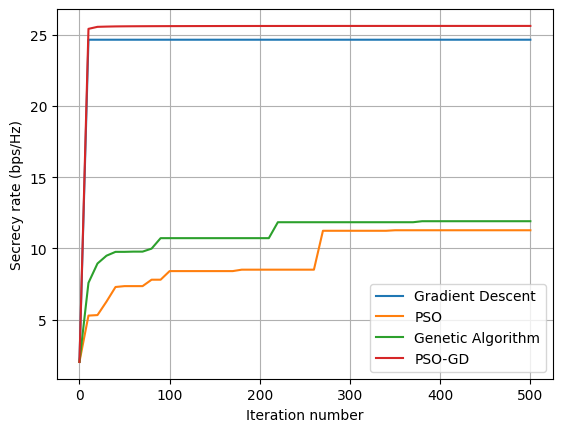

In [35]:
iterations = range(0, num_cycles+10, 10)

# Plotting the data
plt.plot(iterations, GD_results, label='Gradient Descent')
plt.plot(iterations, PSO_results, label='PSO')
plt.plot(iterations, GA_results[0:len(iterations)], label='Genetic Algorithm')
plt.plot(iterations, PSO_GD_results, label='PSO-GD')

plt.xlabel('Iteration number')
plt.ylabel('Secrecy rate (bps/Hz)')
plt.grid(True)
plt.legend()
plt.show()


In [36]:
# Best results of each methods
print("Best Secrecy Rate GD:", max(GD_results))
print("Best Secrecy Rate PSO:", max(PSO_results))
print("Best Secrecy Rate GA:", max(GA_results))
print("Best Secrecy Rate PSO-GD:", max(PSO_GD_results))

Best Secrecy Rate GD: [24.6548294]
Best Secrecy Rate PSO: [11.27448635]
Best Secrecy Rate GA: [17.00556469]
Best Secrecy Rate PSO-GD: [25.62364522]
